In [1]:
%load_ext autoreload
%autoreload 2
%env GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/

import sys,glob,os,errno,warnings

import os
import numpy as np
import scipy.integrate
import astropy
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel,pixel_to_skycoord
from astropy.coordinates import SkyCoord,match_coordinates_sky
from astropy.table import Table,vstack,hstack
from astropy.constants import h, c
from astropy import units as u
from astropy.stats import SigmaClip
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
import matplotlib
from matplotlib import pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import AsinhStretch
from scipy.ndimage import gaussian_filter
from gammapy.maps import RegionGeom, RegionNDMap, MapAxis
from gammapy.datasets import Dataset, Datasets, SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator, FluxPoints
from gammapy.irf import EDispKernelMap
from astroquery.sdss import SDSS
from astropy.time import Time, TimeDelta
from gammapy.data import GTI

from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    PiecewiseNormSpectralModel,
    SkyModel, 
    Models,
    GaussianPrior,
)

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from utils import (
    mkdir_p
)
from starcatalogs import (
    PS1_Catalog,SDSS_Catalog
)

env: GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/


In [2]:
basedir = os.path.abspath("../../../")
outdir  = f"{basedir}/Liverpool_IOO/MJD60384/"

class PhotometricImage(object):
    def __init__(self):
        self.catalog_query = None

    def load_image(self,f):
        print(f'######## Working on {f} #########')
        self.filename = f
        self.hdus    = pyfits.open(f)
        self.data    = self.hdus[0].data
        self.header  = self.hdus[0].header
        self.wcs     = WCS(self.header)
        self.filter  = self.header['FILTER1'].split('-')[1].lower()
        self.srcname = self.header['OBJECT']
        
        interval  = Time([self.header['DATE-OBS'],self.header['DATE-OBS']])
        interval[1] += TimeDelta(self.header['EXPTIME'],format='sec')
        self.gti = GTI.from_time_intervals([interval])

    def check_hotcoldpixels(self,sigma=3,hot_devfactor=1e3,cold_devfactor=1e-4):
        self.smoothdata = scipy.ndimage.gaussian_filter(self.data,sigma=sigma)
        badpixels=(self.data/self.smoothdata)
        print(' * Possible hot  pixels',np.sum(badpixels>hot_devfactor))
        print(' * Possible cold pixels',np.sum(badpixels<cold_devfactor))
        #self.data[badpixels>hot_devfactor]  = self.smoothdata[badpixels>hot_devfactor]
        #self.data[badpixels<cold_devfactor] = self.smoothdata[badpixels<cold_devfactor]
    
    def load_calibration_stars_from_catalogs(self,match_radius=2*u.arcsec):
        print('Query the SDSS catalog')
        footprint  = self.wcs.calc_footprint()
        size_ra    = self.wcs.calc_footprint()[:,0].max()-self.wcs.calc_footprint()[:,0].min()
        size_dec   = self.wcs.calc_footprint()[:,1].max()-self.wcs.calc_footprint()[:,1].min()
        center_ra  = (self.wcs.calc_footprint()[:,0].max()+self.wcs.calc_footprint()[:,0].min())/2.
        center_dec = (self.wcs.calc_footprint()[:,1].max()+self.wcs.calc_footprint()[:,1].min())/2.

        # Allow to re-use the same query
        if self.catalog_query is None:
            # SDSS catalog (u,g,r,i,z)
            self.catalog_query = SDSS_Catalog(center_ra,
                                              center_dec,
                                              60*max([np.sqrt(size_ra**2+size_dec**2)/2.]))
        
            self.catalog = self.catalog_query.table.copy()
            self.catalog['skycoords'] = [SkyCoord(star['ra'],star['dec'],unit='deg')\
                                         for star in self.catalog]

            # PS1 catalog (g,r,i,z)
            self.ps1catalog = PS1_Catalog(center_ra,center_dec,0.2).table
            self.ps1catalog['skycoords'] = [SkyCoord(star['raMean'],star['decMean'],unit='deg')\
                                            for star in self.ps1catalog]
            
            # match both catalogs:
            stack_rows = []
            for row in self.catalog:
                idx, sep2d, dist3d = match_coordinates_sky(row['skycoords'], self.ps1catalog['skycoords'])
                # Define a matching radius (e.g., 1 arcsec)
                if sep2d < match_radius:
                    joint_row   = hstack([row, self.ps1catalog[idx]])
                    stack_rows += joint_row

            self.catalog = vstack(stack_rows)
            self.catalog['skycoords'] = self.catalog['skycoords_1']

            # Check common magnitudes (g,r,i,z) between catalogs. 
            # If we see significant deviations, remove the star
            good_stars = np.ones(len(self.catalog),dtype=bool)
            for filt in ['g','r','i','z']:
                mag_sdss = self.catalog[filt]
                mag_ps1c = self.catalog[f'{filt}MeanPSFMag']
                err_sdss = self.catalog[f'Err_{filt}']
                err_ps1c = self.catalog[f'{filt}MeanPSFMagErr']
                mag_diff = np.abs(mag_sdss-mag_ps1c)
                self.catalog[f'Err_{filt}'] = [max([mag_diff[k],err_sdss[k],err_ps1c[k]]) \
                                               for k,m in enumerate(mag_diff)]
                good_stars *= (mag_diff < 0.2)
            
            self.catalog = self.catalog[good_stars]

    def sel_fully_contained_stars(self,margin=50):
        # Check containment
        self.positions = np.transpose(skycoord_to_pixel(self.catalog['skycoords'],self.wcs))
        contained = []
        for p in self.positions:
            if (p[0] < margin):
                contained.append(False)
                continue
            elif p[0] > self.wcs.pixel_shape[0]-margin:
                contained.append(False)
                continue
            elif (p[1] < margin):
                contained.append(False)
                continue
            elif p[1] > self.wcs.pixel_shape[1]-margin:
                contained.append(False)
                continue
            else:
                contained.append(True)

        self.catalog = self.catalog[np.asarray(contained)]
        print('Fully contained stars:',f' ... {len(self.catalog)}')
        self.positions = np.transpose(skycoord_to_pixel(self.catalog['skycoords'],self.wcs))

    def calibrate_zeropoint(self,threshold=5,r_on=7,r_in=15,r_out=50,max_mag_cat=20,max_zp_error=0.5):
        print('Calculating zero point')
        # Set radii for aperture photometry
        self.r_on  = r_on
        self.r_in  = r_in
        self.r_out = r_out
        
        # centroid correction
        positions = self.positions
        for it in range(1):
            positions = ApertureStats((self.data-np.median(self.data)), 
                                       CircularAperture(positions, r=self.r_on), 
                                       sigma_clip=None).centroid
        
        self.aperture = CircularAperture(positions, r=self.r_on)
        self.annulus_aperture = CircularAnnulus(positions, r_in=self.r_in, r_out=self.r_out)

        sigclip = SigmaClip(sigma=5.0, maxiters=5)
        aper_stats = ApertureStats(self.data, self.aperture, sigma_clip=None)
        bkg_stats = ApertureStats(self.data, self.annulus_aperture, sigma_clip=sigclip)
        alpha = aper_stats.sum_aper_area.value / bkg_stats.sum_aper_area.value

        on         = aper_stats.sum
        off        = bkg_stats.sum
        excess     = on - off*alpha
        excess_err = np.sqrt(off*alpha)
        saturated  = aper_stats.max >= self.header['SATURATN']
        
        ### Check stars that are truly detected in the image
        detected     = excess/excess_err > threshold
        aper_stats   = aper_stats[detected]
        bkg_stats    = bkg_stats[detected]
        alpha        = alpha[detected]
        on           = on[detected]
        off          = off[detected]
        excess       = excess[detected]
        excess_err   = excess_err[detected]
        saturated    = saturated[detected]

        print(' * Removing undetected stars')
        catalog = self.catalog[detected]
        print('   -> Will keep',len(catalog),'out of',len(detected))

        zero_point     = np.asarray(catalog[f'{self.filter}'] + 2.5*np.log10(excess))
        err_zp_cat     = np.asarray(catalog[f'Err_{self.filter}'].value,dtype=float)
        err_zp_photo   = np.asarray(2.5*(excess_err/excess)*1./np.log(10),dtype=float)        
        zero_point_err = np.sqrt(err_zp_cat**2 + err_zp_photo**2,dtype=float)

        ZDTable = Table([catalog['skycoords'],aper_stats.sum,bkg_stats.sum,
                         alpha,excess,excess_err,
                         catalog[f'{self.filter}'],
                         catalog[f'Err_{self.filter}'],
                         zero_point,zero_point_err,saturated],
                        names=['coords','on','off','alpha',
                               'excess','excess_err',
                               'mag_cat','mag_cat_err',
                               'zp','zp_err','saturated'])

        self.n_cal_stars = len(ZDTable)
        # Remove high magnitude stars.
        print(' * Star quality checks: ')
        if len(ZDTable)>=4:
            ZDTable = ZDTable[(ZDTable['mag_cat']<max_mag_cat)]
            n_afterhighmag = len(ZDTable)
            print('   -> Will keep',n_afterhighmag,'out of',self.n_cal_stars,'[high mag. stars removal]')
        # Remove saturated stars
        if len(ZDTable)>=4:
            ZDTable = ZDTable[~ZDTable['saturated']]
            n_aftersaturation = len(ZDTable)
            print('   -> Will keep',n_aftersaturation,'out of',n_afterhighmag,'[saturated stars removal]')
        # Remove those with large ZP errors.
        if len(ZDTable)>=4:
            ZDTable = ZDTable[(ZDTable['zp_err'] < max_zp_error)]
            n_afterzperr = len(ZDTable)
            print('   -> Will keep',n_afterzperr,'out of',n_aftersaturation,'[high ZP err star removal]')
        # if we have enough stars, remove outliers:
        if len(ZDTable)>=4:
            filt = (ZDTable['zp']-np.median(ZDTable['zp']) < 2.*np.std(ZDTable['zp']))
            print('   -> Will keep',np.sum(filt),'out of',len(filt), '[outlier removal, 2-sigma filter, 1st]')
            ZDTable = ZDTable[filt]
        if len(ZDTable)>=4:
            filt = (ZDTable['zp']-np.median(ZDTable['zp']) < 2.*np.std(ZDTable['zp']))
            print('   -> Will keep',np.sum(filt),'out of',len(filt), '[outlier removal, 2-sigma filter], 2nd')
            ZDTable = ZDTable[filt]

        zero_point  = ZDTable['zp']
        weights     = (1./ZDTable['zp_err'])**2
        sum_weights = np.sum(weights)
        
        self.ZP_average_val  = np.sum(zero_point*weights)/sum_weights
        self.ZP_average_err  = np.sqrt(np.std(zero_point)**2/len(weights) + 1./sum_weights)
        self.ZDTable = ZDTable
        self.n_cal_stars_after = len(ZDTable)

    def load_LT_filter_curves(self):
        print('Loading Liverpool filter data')
        ioo_response = Table.read(
            f"{basedir}/Liverpool_IOO/ioo_filter_throughput_and_qe.txt",
            delimiter='\t',names=['wav','u','g','r','i','z','B','V','QE','CW'],
            comment='#',format='ascii.csv')
        ioo_response['QE'][np.isnan(ioo_response['QE'])] = 0
        for k,filt in enumerate(['u','g','r','i','z', 'QE', 'CW']):
            ioo_response[filt] *= 0.01

        self.filter_transmission = Table(
            [ioo_response['wav'],
            ioo_response[self.filter]*ioo_response['QE']*ioo_response['CW']],
            names=['wav','T']
        )

    def calculate_exposure(self):
        print('Calculating exposures for gammapy')
        wav = self.filter_transmission['wav']
        tra = self.filter_transmission['T']
        
        self.trapz0 = scipy.integrate.trapezoid(tra, x=wav) 
        self.trapz1 = scipy.integrate.trapezoid(tra*wav, x=wav) 
        self.center_lambda = self.trapz1 / self.trapz0

        Fstar = np.asarray(10**(-0.4*(self.ZDTable['mag_cat'].value+48.60)),dtype=float)
        Fstar_err = np.asarray(Fstar*np.log(10)*0.4*self.ZDTable['mag_cat_err'].value,dtype=float)
        Excess = np.asarray(self.ZDTable['excess'].value,dtype=float)
        Excess_err = np.asarray(self.ZDTable['excess_err'].value,dtype=float)
        Acol = Excess*(self.trapz1/self.trapz0)*h.to('erg *s').value / (Fstar*self.trapz0)
        Acol_err = Acol * np.sqrt((Excess_err/Excess)**2 + (Fstar_err / Fstar)**2)
        self.ZDTable['Flux'] = Fstar
        self.ZDTable['FluxError'] = Fstar_err
        self.ZDTable['Exposure'] = Acol
        self.ZDTable['ExposureError'] = Acol_err

        weights = 1./(Acol_err**2)
        sum_weights = np.sum(weights)
        self.Acol_mean = np.sum(Acol*weights)/sum_weights
        self.Acol_err  = np.sqrt(np.std(Acol)**2/len(weights) + 1./sum_weights)

    def get_target_photometry(self,target):
        print('Doing photometry on',target.ra.deg,target.dec.deg)
        ### Photometry of the target
        self.target = target
        pos_target = np.transpose(skycoord_to_pixel(self.target,self.wcs))
        
        # centroid correction
        for it in range(1):
            pos_target = ApertureStats((self.data-np.median(self.data)), 
                                        CircularAperture(pos_target, r=self.r_on), 
                                        sigma_clip=None).centroid

        aperture_target = CircularAperture(pos_target, r=self.r_on)
        annulus_aperture_target = CircularAnnulus(pos_target, r_in=self.r_in, r_out=self.r_out)

        # Do ON-OFF photometry
        sigclip = SigmaClip(sigma=5.0, maxiters=5)
        aper_stats = ApertureStats(self.data, aperture_target, sigma_clip=None)
        bkg_stats = ApertureStats(self.data, annulus_aperture_target, sigma_clip=sigclip)
        self.alpha = aper_stats.sum_aper_area.value / bkg_stats.sum_aper_area.value

        self.on         = aper_stats.sum
        self.off        = bkg_stats.sum
        self.excess     = self.on - self.off*self.alpha

        self.excess_err = np.sqrt(self.off*self.alpha**2 + self.on)
        self.mag_target     = -2.5*np.log10(self.excess) + self.ZP_average_val
        self.mag_target_err = np.sqrt( (self.ZP_average_err)**2 + (2.5*self.excess_err/(self.excess*np.log(10)))**2)
        self.mag_text = f'{self.srcname}: {self.filter}_mag = {self.mag_target:.4f} +/- {self.mag_target_err:.4f}'
        print(' *',self.mag_text)

    def calculate_sed_point(self):
        # Classical SED calculation (ignores unknown source spectrum !)
        self.filter_center = c.to('AA/s')/(self.center_lambda*u.AA)
        
        self.fv         = 10**(-0.4*(self.mag_target+48.60)) *u.Unit('erg cm-2')
        self.fv_err     = self.fv*np.log(10)*0.4*self.mag_target_err
        self.e2dnde     = self.filter_center*self.fv
        self.e2dnde_err = self.filter_center*self.fv_err
        print(f' * {self.e2dnde.value:.4e} +/- {self.e2dnde_err.value:.4e} erg cm-2 s-1')

    def build_photometry_table(self):
        print('Building table with photometry for the target')
        dname = self.header['TELESCOP'].replace(' ','.')+'_'+\
                self.header['INSTRUME'].replace(' ','')+'_'+\
                self.header['FILTER1']+'_'+\
                self.header['EXPID']
        
        self.PhotTable = Table(
            np.transpose(
             [self.srcname, self.filename.split('/')[-1], dname, self.header['RA'],self.header['DEC'],
              self.header['ORIGIN'],self.header['INSTRUME'],self.header['FILTER1'],self.filter_center,
              self.header['MJD'],self.header['DATE-OBS'],self.header['EXPTIME'],
              self.ZP_average_val,self.ZP_average_err,self.n_cal_stars,self.n_cal_stars_after,self.r_on,self.r_in,self.r_out,
              self.on,self.off,self.excess,self.excess_err,self.alpha,self.mag_target,self.mag_target_err,
              self.fv,self.fv_err,self.e2dnde,self.e2dnde_err]),
            names=['srcname','fname','dname','ra','dec',
                   'origin','instrument','filter','filter_center',
                   'mjd','date-obs','exptime',
                   'zeropoint','zeropoint_err','n_cal_stars','n_cal_stars_filt','r_on','r_off_1','r_off_2',
                   'on','off','excess','excess_err','alpha','mag_obs','mag_obs_err',
                   'fnu','fnu_err','e2dnde_obs','e2dnde_obs_err'],
            units=['','','','','',
                   '','','','Hz',
                   '','','s',
                   'mag','mag','','','px','px','px',
                   'cts','cts','cts','cts','','mag','mag',
                   'erg cm-2 s-1 Hz-1', 'erg cm-2 s-1 Hz-1', 
                   'erg cm-2 s-1', 'erg cm-2 s-1']
        )
    
    def create_dataset(self):
        print('Building Gammapy dataset')
        wav = self.filter_transmission['wav']
        tra = self.filter_transmission['T']
        frq = c.to('AA/s').value/wav

        # From here we can either interpolate into a regular grid in energy, or leave the default one (regular in wavelength).
        energies = h.to('eV*s').value * frq[::-1]
        exposure = tra[::-1]*self.Acol_mean * u.Unit('cm2*s')
        edges    = tra[::-1]>(np.max(tra[::-1])/10.)
        edges    = min(energies[edges])*u.eV,max(energies[edges])*u.eV
        
        energy_axis = MapAxis(nodes=[e.value for e in edges],node_type='edges',interp='lin',name='energy',unit='eV')
        energy_true = MapAxis(energies.value,node_type='center',interp='lin',name='energy_true',unit='eV')
        
        myreg_on = RegionNDMap.create(
            region = None,
            axes = [energy_axis],
            data = np.asarray([[[self.on]]]),
        )
        myreg_off = RegionNDMap.create(
            region = None,
            axes = [energy_axis],
            data = np.asarray([[[self.off]]]),
        )
        myreg_exposure = RegionNDMap.create(
            region = None,
            axes = [energy_true],
            data = np.asarray([[[e.value]] for e in exposure]),
            unit='cm2 s',
            meta={'livetime': self.header['EXPTIME']*u.s,},
        )
        myreg_edisp = RegionNDMap.create(
            region = None,
            axes = [energy_axis,energy_true],
            data = np.asarray([[[[1]]] for e in exposure]),
        )
        myedisp = EDispKernelMap(
            edisp_kernel_map = myreg_edisp,
            exposure_map = myreg_exposure,
        )
        myacceptance = RegionNDMap.create(
            region = None,
            axes = [energy_axis],
            data = np.asarray([[[self.Acol_mean]]]),
        )
        myacceptance_off = RegionNDMap.create(
            region = None,
            axes = [energy_axis],
            data = np.asarray([[[self.Acol_mean/self.alpha]]]),
        )

        name = self.header['TELESCOP'].replace(' ','.')+'_'+\
               self.header['INSTRUME'].replace(' ','')+'_'+\
               self.header['FILTER1']+'_'+\
               self.header['EXPID']
        
        self.Dataset = SpectrumDatasetOnOff(
            models=None, 
            counts=myreg_on, 
            counts_off=myreg_off, 
            acceptance=myacceptance, 
            acceptance_off=myacceptance_off, 
            exposure=myreg_exposure, 
            mask_fit=None, 
            psf=None, 
            edisp=myedisp, 
            name=name, 
            mask_safe=None, 
            gti=self.gti, 
            meta_table=None, 
            meta={'exposure_rel_error': self.Acol_err/self.Acol_mean},
        )
    
    def plot_image(self):
        figure = plt.figure(figsize=(6,6),dpi=120)
        ax = figure.add_subplot(111, projection=self.wcs, label='overlays')

        norm = ImageNormalize(stretch=AsinhStretch(),
                              vmax=np.mean(self.data)*10,
                              vmin=np.median(self.data)*0.8)

        im = ax.imshow(gaussian_filter(self.data,2),
                       cmap='Greys_r', 
                       origin='lower', 
                       norm=norm,
                       interpolation='nearest',zorder=-15,)

        ax.grid(ls='dotted',lw=1,alpha=0.25)
        ax.set_xlabel("RA J2000", size='large',color='black')
        ax.set_ylabel("Dec J2000", size='large',color='black')

        ax.coords['ra'].set_ticklabel_position('l')
        ax.coords['dec'].set_ticklabel_position('b')

        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')

        # Plotting the stars as small circles
        ax.errorbar(x=self.positions[:,0], 
                    y=self.positions[:,1], 
                    marker='o', 
                    ms=5, 
                    mec='tab:red',
                    mew=0.8,
                    mfc=(1.0, 0.0, 0.0, 0.2), 
                    label='Star',
                    ls='None',
                   )
        
        return(figure)

## Run the calibration on each image:
1. Identifies stars from the SDSS catalog.
2. Performs photometry on those stars to compare the counts with the catalog fluxes.
3. Gets the zero points (ZP) and the effective areas.
4. Measures the counts, flux and magnitude of the target source
5. Creates the ZP table, and the PhotTable for the source

In [3]:
warnings.filterwarnings("ignore", category=astropy.wcs.FITSFixedWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

full_table = Table()

datasets   = []
phot_table = []
zd_tables  = []

bad_tracking_images = ["h_e_20240314_60_1_1_1.fits", "h_e_20240314_60_2_1_1.fits", 
                       "h_e_20240314_63_2_1_1.fits", "h_e_20240314_42_1_1_1.fits"
                       "h_e_20240314_85_2_1_1.fits", "h_e_20240314_86_2_1_1.fits", 
                       "h_e_20240314_87_2_1_1.fits","h_e_20240314_88_2_1_1.fits", 
                       "h_e_20240314_89_1_1_1.fits",
                      ]
PI = PhotometricImage()
for k,f in enumerate(sorted(glob.glob('/mnt/sdb1/Optical/OP313/Liverpool_NuSTARNight2/h_e*.fits'))):
    if f.split('/')[-1] in bad_tracking_images: 
        print(f'skipping {f}')
        continue
    
    PI.load_image(f)
    PI.check_hotcoldpixels()
    PI.load_calibration_stars_from_catalogs()
    PI.sel_fully_contained_stars()
    # smaller integration for u and g filters as the signals are weaker
    if PI.filter == 'u':
        PI.calibrate_zeropoint(threshold=5,r_on=8)
    else:
        PI.calibrate_zeropoint(threshold=5,r_on=12)
    PI.load_LT_filter_curves()
    PI.calculate_exposure()
    PI.get_target_photometry(SkyCoord.from_name('OP313'))
    PI.calculate_sed_point()
    PI.build_photometry_table()
    PI.create_dataset()
    datasets.append(PI.Dataset)
    phot_table.append(PI.PhotTable)
    zd_tables.append(PI.ZDTable)

vstack(phot_table).write(f'{outdir}/PhotometryTable.ecsv', 
                         format='ascii.ecsv',overwrite=True)

######## Working on /mnt/sdb1/Optical/OP313/Liverpool_NuSTARNight2/h_e_20240314_42_1_1_1.fits #########
 * Possible hot  pixels 0
 * Possible cold pixels 0
Query the SDSS catalog
https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?ra=197.60873450597126&dec=32.363307681805296&radius=0.2&nDetections.gt=10&gMeanPSFMag.gt=10&gMeanPSFMag.lt=21&gMeanPSFMagErr.gt=0.0&gMeanPSFMagErr.lt=0.2&gMeanPSFMagStd.gt=0.0&gMeanPSFMagStd.lt=0.2&gQfPerfect.gt=0.85&rMeanPSFMag.gt=10&rMeanPSFMag.lt=21&rMeanPSFMagErr.gt=0.0&rMeanPSFMagErr.lt=0.2&rMeanPSFMagStd.gt=0.0&rMeanPSFMagStd.lt=0.2&rQfPerfect.gt=0.85&zMeanPSFMag.gt=10&zMeanPSFMag.lt=21&zMeanPSFMagErr.gt=0.0&zMeanPSFMagErr.lt=0.2&zMeanPSFMagStd.gt=0.0&zMeanPSFMagStd.lt=0.2&zQfPerfect.gt=0.85&iMeanPSFMag.gt=10&iMeanPSFMag.lt=21&iMeanPSFMagErr.gt=0.0&iMeanPSFMagErr.lt=0.2&iMeanPSFMagStd.gt=0.0&iMeanPSFMagStd.lt=0.2&iQfPerfect.gt=0.85&columns=objID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CqualityFlag%2CgMeanPSFMag%2CrMeanPSFM

## Check stability of the photometry (Exposure and mag)

Text(0, 0.5, 'Exposure [cm$^2$ s$^1$]')

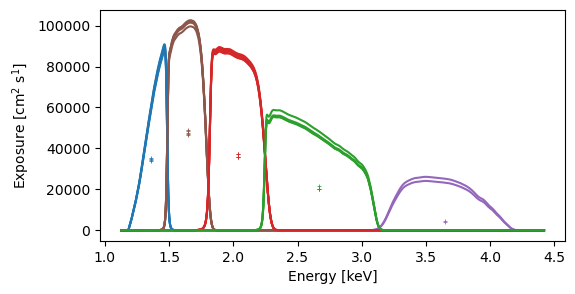

In [4]:
plt.figure(figsize=(6,3))
colors = {'Z': 'C0','R':'C3','I':'C5','G':'C2','U':'C4'}
for d in datasets:
    plt.plot(
        d.exposure.geom.axes['energy_true'].center,
        d.exposure.data.flatten(),
        c=colors[d.name.split('SDSS-')[-1].split('_')[0]]
    )
    plt.scatter(
        x=d.npred().geom.axes['energy'].center[d.npred().data.argmax()],
        y=(d.counts.data.sum() - d.background.data.sum())/4,
        c=colors[d.name.split('SDSS-')[-1].split('_')[0]],
        fc='white', marker='+',lw=0.55,s=6,
    )
plt.xlabel('Energy [keV]')
plt.ylabel('Exposure [cm$^2$ s$^1$]')

Text(0, 0.5, 'Magnitude')

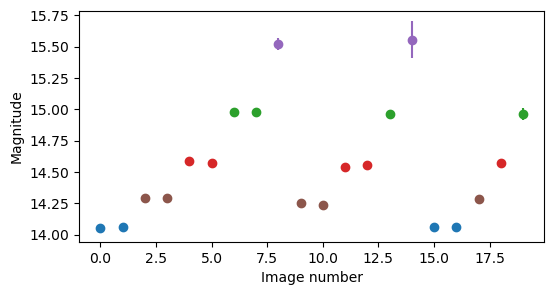

In [5]:
plt.figure(figsize=(6,3))

for j,item in enumerate(vstack(phot_table)):
    plt.errorbar(y=float(item['mag_obs']),
                 yerr=float(item['mag_obs_err']),
                 x=j,
                 ls='None',marker='o', color=colors[item['filter'].split('SDSS-')[-1]])
plt.xlabel('Image number')
plt.ylabel('Magnitude')

## Prepare the information about systematics for the dataset
We will embed the systematics coming from the ZP calculation (i.e. star-by-star variations) as a Piecewise norm model with priors of mean 1 and width the estimated error coming from the ZP/Effective area estimation.

In [6]:
exposure_rel_errors = {}
central_energies    = {}

Liverpool_IOO_datasets = Datasets(datasets)

for d in Liverpool_IOO_datasets:
    f = d.name.split('SDSS-')[-1].split('_h')[0].lower()
    if f not in exposure_rel_errors:
        exposure_rel_errors[f]  = [d.meta['exposure_rel_error']]
        central_energies[f]     = [d.counts.geom.axes['energy'].center[0].to('eV').value]
    else:
        exposure_rel_errors[f] += [d.meta['exposure_rel_error']]
        central_energies[f]    += [d.counts.geom.axes['energy'].center[0].to('eV').value]

for f in exposure_rel_errors:
    exposure_rel_errors[f] = np.mean(exposure_rel_errors[f])
    central_energies[f] = np.mean(central_energies[f])*u.eV

central_energies_exposure_err = {v: exposure_rel_errors[k] \
                                 for k, v in central_energies.items()}

In [7]:
### Sky models
SourceSpectrum = LogParabolaSpectralModel()
SourceSpectrum.reference.value = 1
SourceSpectrum.reference.unit  = 'eV'
SourceSpectrum.amplitude.value = 10
SourceSpectrum.amplitude.unit = 'eV-1 s-1 cm-2'
SourceSpectrum.amplitude.min  = 1e-6
SourceSpectrum.amplitude.max  = 1e6
SourceSpectrum.alpha.value = 2
SourceSpectrum.alpha.min  = -2.0
SourceSpectrum.alpha.max  = 8.0
SourceSpectrum.beta.value = 0.1
SourceSpectrum.beta.min  = -2.0
SourceSpectrum.beta.max  = 2.0

aeff_error_dict = {}

AeffSyst = PiecewiseNormSpectralModel(energy=sorted(central_energies.values())*u.eV,interp='lin')
for k,ce in enumerate(sorted(central_energies.values())):
    AeffSyst.parameters[k].error = central_energies_exposure_err[ce]
    AeffSyst.parameters[k].prior = GaussianPrior(mu=1, sigma=central_energies_exposure_err[ce])

Target = SkyModel(name='OP313', spectral_model=AeffSyst*SourceSpectrum)
Liverpool_IOO_datasets.models = Models([Target])


## Save the dataset and model

In [8]:
#os.chdir("/home/mnievas/Projects/gammapy_mwl_workflow/Notebooks_generators/")
mkdir_p(f"{outdir}")
for g in glob.glob(f"{outdir}/*.yaml*"): os.remove(g)
for g in glob.glob(f"{outdir}/*.fits*"): os.remove(g)

Liverpool_IOO_datasets.write(
    filename=f"{outdir}/dataset.yaml",
    filename_models=f"{outdir}/models.yaml",
    write_covariance=False,
    overwrite=True
)

/tmp/ipykernel_3028962/3353979580.py:13: RuntimeWarning: invalid value encountered in power
  ax.imshow(transform(gaussian_filter(cutoutdata.data,0.5)**0.75),cmap='Greys',vmax=0.5)
/tmp/ipykernel_3028962/3353979580.py:13: RuntimeWarning: invalid value encountered in power
  ax.imshow(transform(gaussian_filter(cutoutdata.data,0.5)**0.75),cmap='Greys',vmax=0.5)
/tmp/ipykernel_3028962/3353979580.py:13: RuntimeWarning: invalid value encountered in power
  ax.imshow(transform(gaussian_filter(cutoutdata.data,0.5)**0.75),cmap='Greys',vmax=0.5)
/tmp/ipykernel_3028962/3353979580.py:13: RuntimeWarning: invalid value encountered in power
  ax.imshow(transform(gaussian_filter(cutoutdata.data,0.5)**0.75),cmap='Greys',vmax=0.5)
/tmp/ipykernel_3028962/3353979580.py:13: RuntimeWarning: invalid value encountered in power
  ax.imshow(transform(gaussian_filter(cutoutdata.data,0.5)**0.75),cmap='Greys',vmax=0.5)
/tmp/ipykernel_3028962/3353979580.py:13: RuntimeWarning: invalid value encountered in power
  a

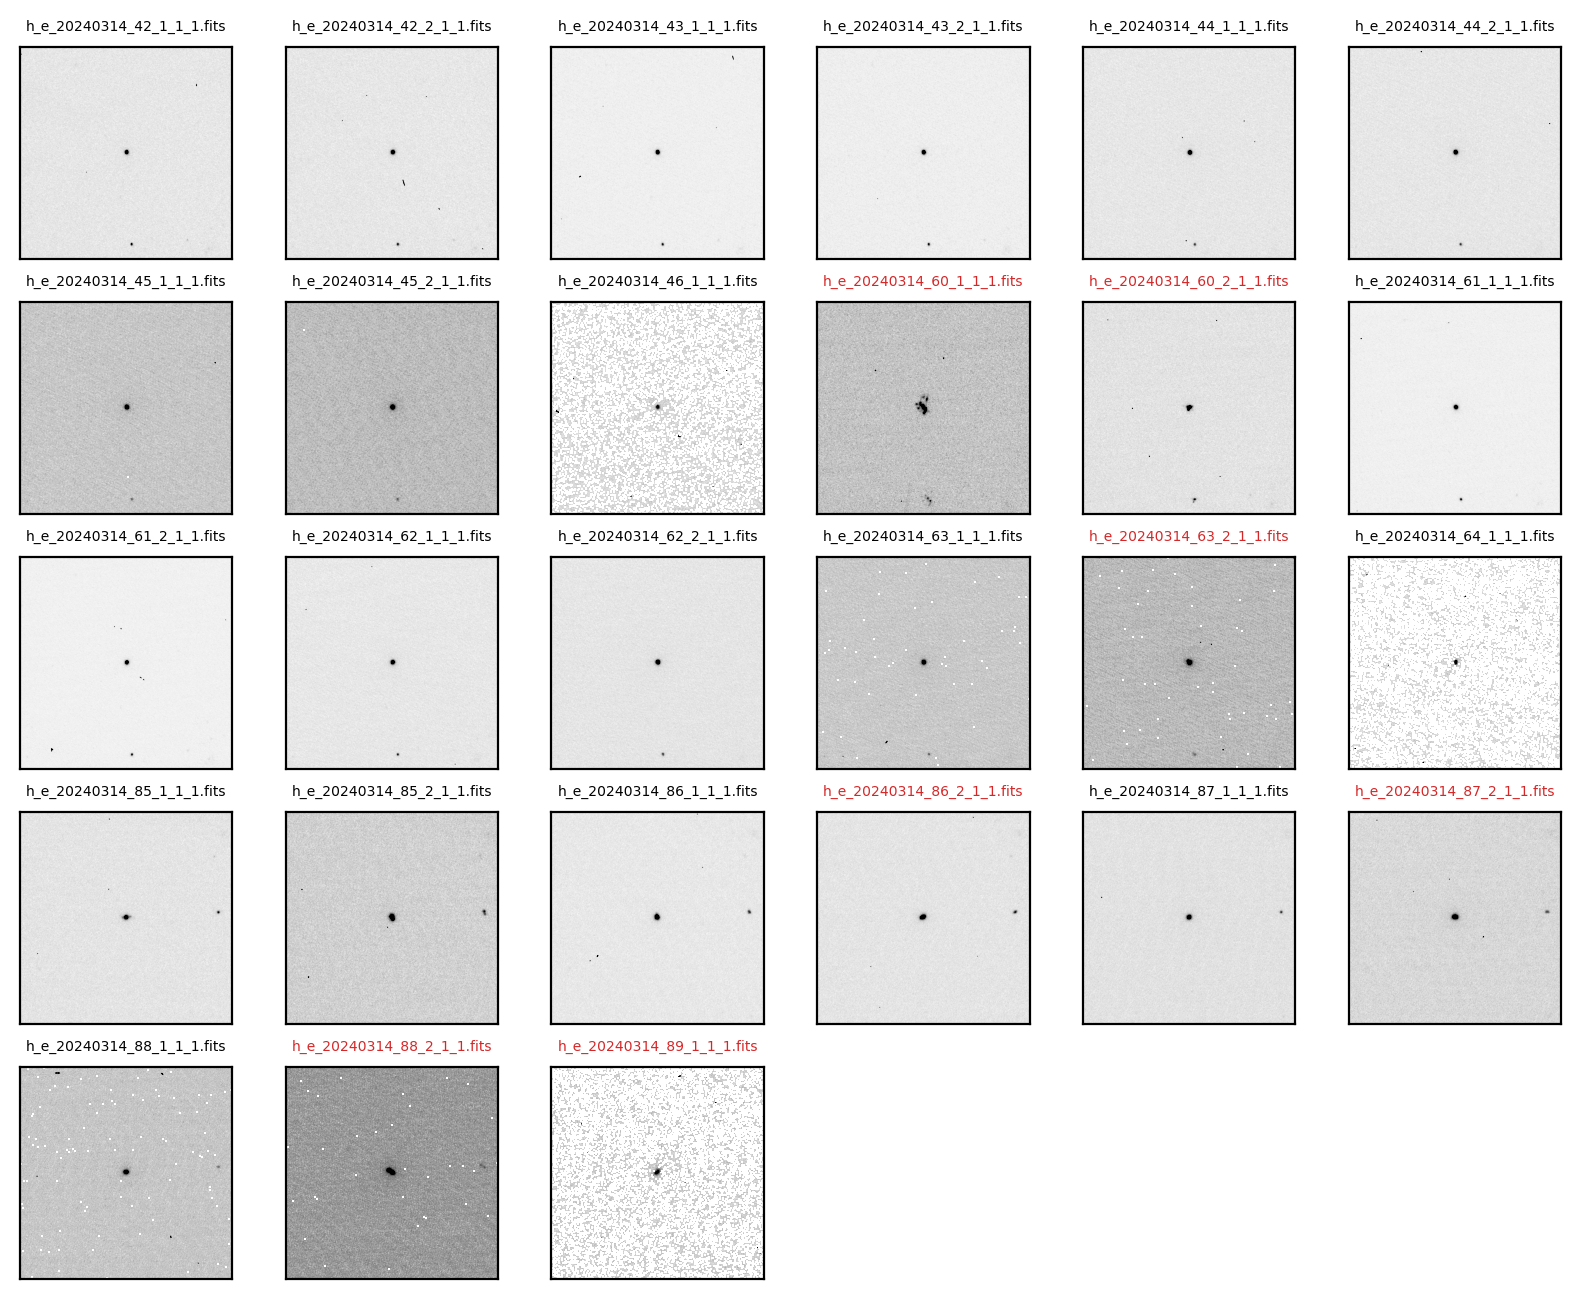

In [9]:
from astropy.io import fits as pyfits
from astropy.visualization import AsinhStretch, PercentileInterval
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

fig = plt.figure(figsize=(10,8),dpi=200)
for k,f in enumerate(sorted(glob.glob("/mnt/sdb1/Optical/OP313/Liverpool_NuSTARNight2/h_e*.fits"))):
    
    hdu = pyfits.open(f)
    transform = AsinhStretch() + PercentileInterval(99.99)
    cutoutdata = Cutout2D(hdu[0].data, position=SkyCoord.from_name('OP313'), size=3*u.arcmin, wcs=WCS(hdu[0]))
    ax = fig.add_subplot(5,6,k+1,projection=cutoutdata.wcs)
    ax.imshow(transform(gaussian_filter(cutoutdata.data,0.5)**0.75),cmap='Greys',vmax=0.5)
    ax.coords['ra'].set_ticks(number=0,direction='out')
    ax.coords['dec'].set_ticks(number=0,direction='out')
    if f.split('/')[-1] in bad_tracking_images:
        ax.tick_params(color='tab:red', labelcolor='tab:red')
        for spine in ax.spines.values():
            spine.set_edgecolor('tab:red')
            ax.set_title(f.split('/')[-1],fontsize='5',color='tab:red')
    else:
        ax.set_title(f.split('/')[-1],fontsize='5')

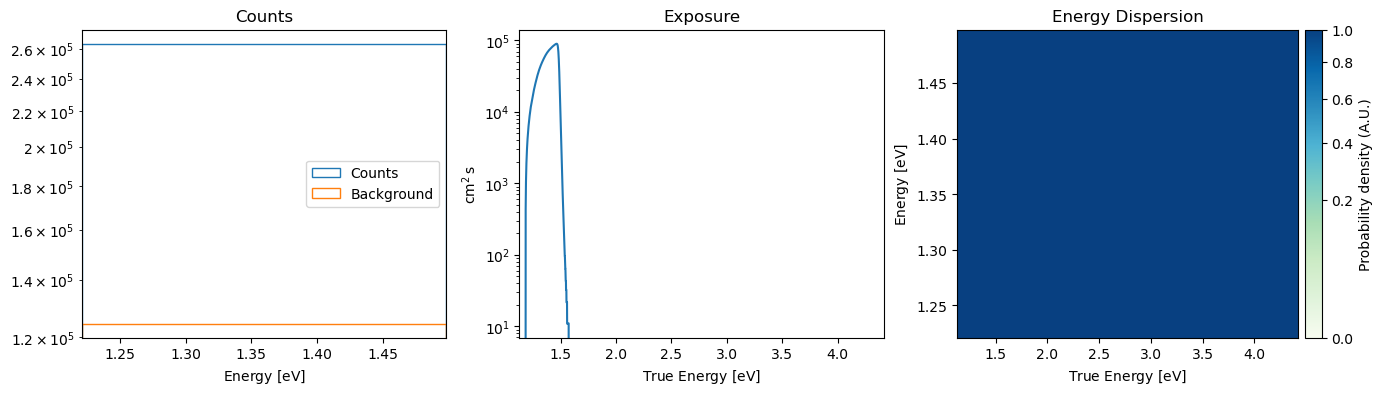

In [10]:
Liverpool_IOO_datasets[1].peek()